## Importación de las librerías

In [1]:
import utils
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

## Conjuntos de entrenamiento y test y CV controller

In [2]:
X_train, X_test, y_train, y_test = utils.get_train_test_data()
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(7776, 12) (1022, 12) (7776,) (1022,)


In [3]:
cv = utils.get_stratified_shuffle_cv()
print(cv)

StratifiedShuffleSplit(n_splits=5, random_state=99, test_size=0.2,
            train_size=0.8)


## Carga del mejor árbol de clasificación

Este será el árbol que se empleará para realizar el **bagging**

In [5]:
decision_tree_model = pickle.load(open('/kaggle/input/decision-tree-model/decision_tree_model.sav', 'rb'))
print(decision_tree_model.criterion)
decision_tree_model

gini


DecisionTreeClassifier(max_depth=10, min_samples_leaf=45, min_samples_split=200,
                       random_state=99)

## Búsqueda del parámetro max_samples del bagging

In [8]:
param_grid = {
    'n_estimators': list(range(50,501,50)),
    'max_samples': list(np.arange(0.1,1.01,0.1))
}

grid_search_cv = GridSearchCV(
    BaggingClassifier(
        base_estimator=DecisionTreeClassifier(criterion=decision_tree_model.criterion, max_depth=decision_tree_model.max_depth,
                                              min_samples_leaf=decision_tree_model.min_samples_leaf, min_samples_split=decision_tree_model.min_samples_split,
                                              random_state=99),
        random_state=99
    ),
    param_grid=param_grid, scoring='roc_auc', cv=cv, verbose=2,
)

grid_search_cv.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END ...................max_samples=0.1, n_estimators=50; total time=   0.2s
[CV] END ...................max_samples=0.1, n_estimators=50; total time=   0.2s
[CV] END ...................max_samples=0.1, n_estimators=50; total time=   0.2s
[CV] END ...................max_samples=0.1, n_estimators=50; total time=   0.2s
[CV] END ...................max_samples=0.1, n_estimators=50; total time=   0.2s
[CV] END ..................max_samples=0.1, n_estimators=100; total time=   0.3s
[CV] END ..................max_samples=0.1, n_estimators=100; total time=   0.3s
[CV] END ..................max_samples=0.1, n_estimators=100; total time=   0.3s
[CV] END ..................max_samples=0.1, n_estimators=100; total time=   0.3s
[CV] END ..................max_samples=0.1, n_estimators=100; total time=   0.3s
[CV] END ..................max_samples=0.1, n_estimators=150; total time=   0.5s
[CV] END ..................max_samples=0.1, n_

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=99, test_size=0.2,
            train_size=0.8),
             estimator=BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=10,
                                                                               min_samples_leaf=45,
                                                                               min_samples_split=200,
                                                                               random_state=99),
                                         random_state=99),
             param_grid={'max_samples': [0.1, 0.2, 0.30000000000000004, 0.4,
                                         0.5, 0.6, 0.7000000000000001, 0.8, 0.9,
                                         1.0],
                         'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400,
                                          450, 500]},
             scoring='roc_auc', verbose=2)

Escogemos como max_samples 0.6, ya que apartir de alli no hay mejora significativa

<AxesSubplot:xlabel='estimators', ylabel='mean_test_score'>

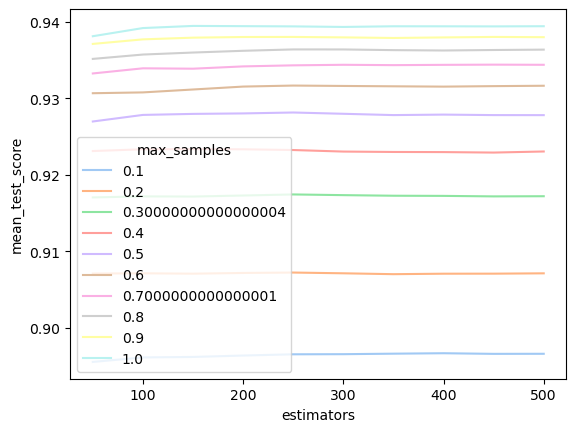

In [10]:
estimators_list = list(grid_search_cv.cv_results_['param_n_estimators'].data)
max_samples_list = list(grid_search_cv.cv_results_['param_max_samples'].data)
mean_test_score_list = list(grid_search_cv.cv_results_['mean_test_score'])
bagging_df = pd.DataFrame(list(zip(estimators_list, max_samples_list, mean_test_score_list)), columns=['estimators', 'max_samples', 'mean_test_score'])
sns.lineplot(data=bagging_df, x="estimators", y="mean_test_score", hue='max_samples', legend="full", palette="pastel")

## Búsqueda del modelo de bagging

In [15]:
param_grid = {
    'n_estimators': list(range(10,300,10))
}

grid_search_cv = GridSearchCV(
    BaggingClassifier(
        base_estimator=DecisionTreeClassifier(criterion=decision_tree_model.criterion, max_depth=decision_tree_model.max_depth,
                                              min_samples_leaf=decision_tree_model.min_samples_leaf, min_samples_split=decision_tree_model.min_samples_split,
                                              random_state=99),
        max_samples = 0.6, random_state=99
    ),
    param_grid=param_grid, scoring='roc_auc', cv=cv, verbose=0, n_jobs=-1
)

grid_search_cv.fit(X_train, y_train)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=99, test_size=0.2,
            train_size=0.8),
             estimator=BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=10,
                                                                               min_samples_leaf=45,
                                                                               min_samples_split=200,
                                                                               random_state=99),
                                         max_samples=0.6, random_state=99),
             n_jobs=-1,
             param_grid={'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90,
                                          100, 110, 120, 130, 140, 150, 160,
                                          170, 180, 190, 200, 210, 220, 230,
                                          240, 250, 260, 270, 280, 290]},
             scoring='roc_auc')

Decidimos que el número de árboles a usar será: **10** ya que la mejora desde 10 a 290 es insignificativa, se pasa de 92.95% a 93.16%

<AxesSubplot:xlabel='estimators', ylabel='mean_test_score'>

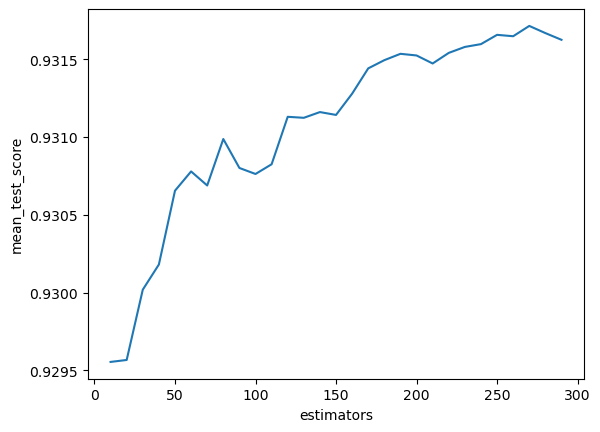

In [18]:
estimators_list = list(grid_search_cv.cv_results_['param_n_estimators'].data)
mean_test_score_list = list(grid_search_cv.cv_results_['mean_test_score'])
bagging_df = pd.DataFrame(list(zip(estimators_list, mean_test_score_list)), columns=['estimators', 'mean_test_score'])
bagging_df['mean_test_score_shift'] = bagging_df['mean_test_score'].shift().fillna(0)
bagging_df['diff'] = (bagging_df['mean_test_score'] - bagging_df['mean_test_score_shift'])
sns.lineplot(data=bagging_df, x="estimators", y="mean_test_score")

In [19]:
bagging_df

,estimators,mean_test_score,mean_test_score_shift,diff
0,10,0.929555,0.000000,0.929555
1,20,0.929568,0.929555,0.000013
2,30,0.930019,0.929568,0.000452
3,40,0.930181,0.930019,0.000162
4,50,0.930655,0.930181,0.000474
5,60,0.930779,0.930655,0.000124
6,70,0.930689,0.930779,-0.000090
7,80,0.930987,0.930689,0.000299
8,90,0.930801,0.930987,-0.000186
9,100,0.930763,0.930801,-0.000039


**Modelo de bagging con árbol de clasificación**

Confusion matrix, without normalization
[[763 209]
 [ 15  35]]


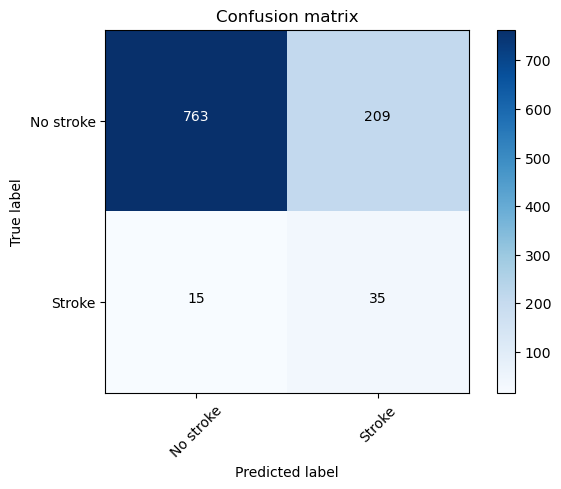

In [33]:
bagging_tree_model = BaggingClassifier(
    base_estimator=DecisionTreeClassifier(criterion=decision_tree_model.criterion, max_depth=decision_tree_model.max_depth,
                                          min_samples_leaf=decision_tree_model.min_samples_leaf, min_samples_split=decision_tree_model.min_samples_split,
                                          random_state=99),
    n_estimators=10, max_samples=0.6, random_state=99
)

bagging_tree_model.fit(X_train, y_train)
y_pred = bagging_tree_model.predict(X_test)

cm = utils.get_confusion_matrix(y_test, y_pred)
utils.plot_confusion_matrix(cm=cm, classes=['No stroke', 'Stroke'])

              precision    recall  f1-score   support

           0       0.98      0.78      0.87       972
           1       0.14      0.70      0.24        50

    accuracy                           0.78      1022
   macro avg       0.56      0.74      0.56      1022
weighted avg       0.94      0.78      0.84      1022



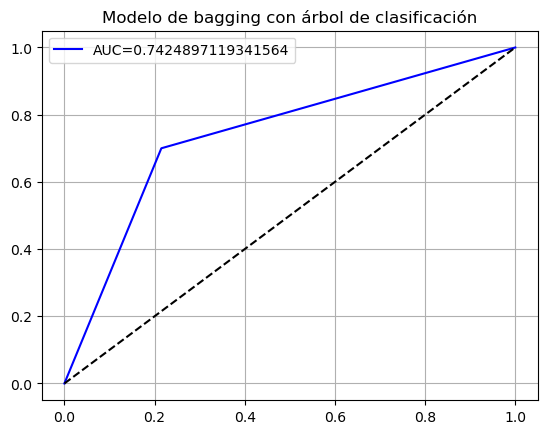

In [34]:
utils.print_metrics(y_test, y_pred, "Modelo de bagging con árbol de clasificación")

## Importancia de las variables

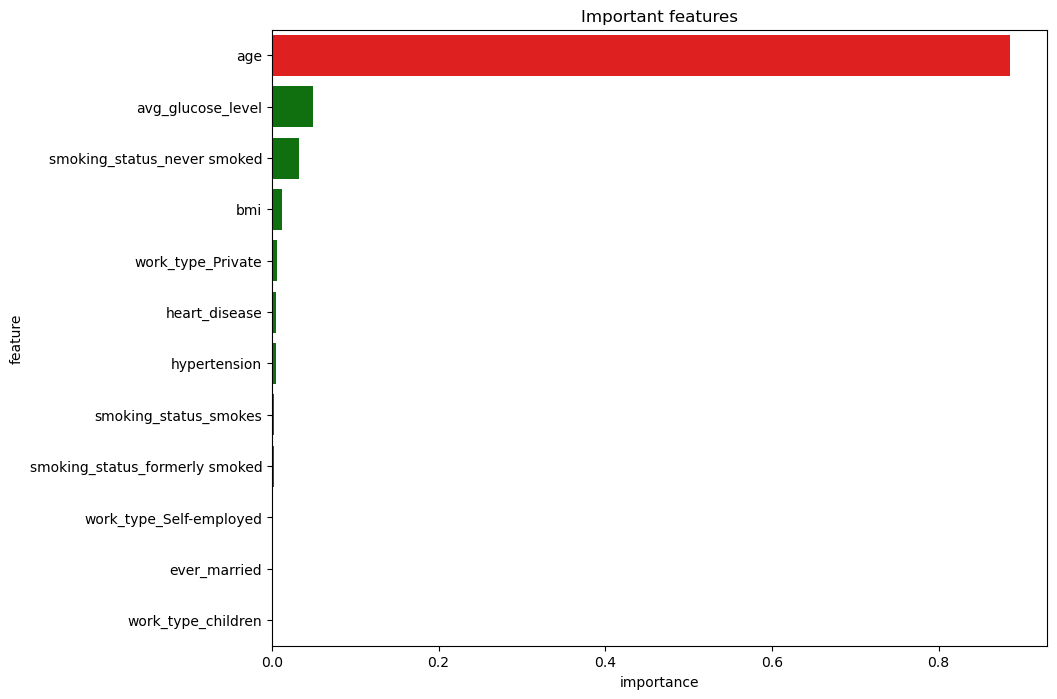

In [35]:
feature_importances = np.mean([
    tree.feature_importances_ for tree in bagging_tree_model.estimators_
], axis=0)
utils.plot_tree_feature_importance(bagging_tree_model.feature_names_in_, feature_importances)

**Guardamos el modelo para la comparativa final**

In [36]:
pickle.dump(bagging_tree_model, open("bagging_tree_model.sav", 'wb'))